<h1> Matsubara fitting for data with continuous spectrum (semicircular density) </h1>

In this notebook, we aim to fit the following Matsubara function:
$$
G(\mathrm i\nu_n) = \int_{-\infty}^{\infty} \frac{1}{\mathrm i\nu_n - w} \rho(w),
$$
where $\rho(w)$ is the semicircular spectral function
$$
\rho(w) = \left\{
    \begin{aligned}
    \frac{2}{\pi}\sqrt{1-w^2}, \quad &-1\leq w\leq 1, \\
    0, \quad &w>1 \text{ and } w<-1.
    \end{aligned}
    \right. 
$$
and $\mathrm i\nu_n$ is the Matsubara frequency:
$$
\mathrm i\nu_n = \left\{
    \begin{aligned}
   \mathrm i \frac{(2n+1)\pi}{\beta}, & \text{ for fermions},\\
   \mathrm i \frac{2n\pi}{\beta}, & \text{ for bosons}.
    \end{aligned}
\right.
$$
Here $\beta$ is the inverse temperature.

Let us first set inverse temperature $\beta$ and the Matsubara frequencies $Z = \{\mathrm i\nu_n\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from adapol import hybfit
import scipy
beta = 20
N = 55
Z = 1j *(np.linspace(-N, N, N + 1)) * np.pi / beta

Now we construct the Matsubara data using the above equation. The integral is evaluated with adaptive quadrature:

In [2]:
def Kw(w, v):
    return 1 / ( v - w)
def semicircular(x):
    return 2 * np.sqrt(1 - x**2) / np.pi
def make_Delta_with_cont_spec( Z, rho, a=-1.0, b=1.0, eps=1e-12):
    Delta = np.zeros((Z.shape[0]), dtype=np.complex128)
    for n in range(len(Z)):
        def f(w):
            return Kw(w , Z[n]) * rho(w)

        # f = lambda w: Kw(w-en[i],Z[n])*rho(w)
        Delta[n] = scipy.integrate.quad(
            f, a, b, epsabs=eps, epsrel=eps, complex_func=True
        )[0]
        

    return Delta

Delta = make_Delta_with_cont_spec( Z, semicircular)

Below we show that by increasing number of modes $N_p$, the fitting error decreases. 

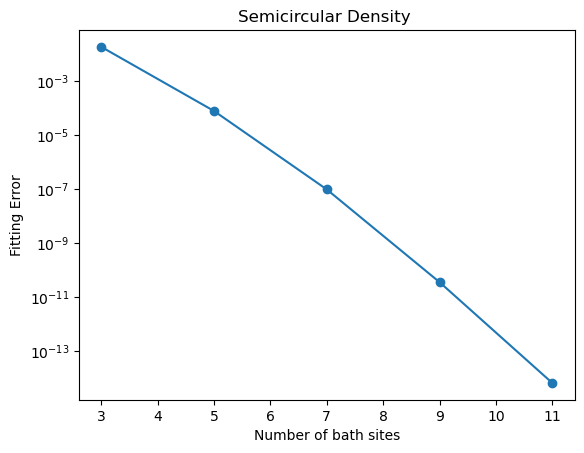

In [3]:
error = []
Nbath = []
for Np in range(2, 12, 2):
    bathenergy, bathhyb, final_error, func = hybfit(Delta, Z, Np = Np, verbose=False)
    Nbath.append(len(bathenergy))
    error.append(final_error)
plt.yscale('log')
plt.plot(Nbath, error, 'o-')
plt.xlabel('Number of bath sites')
plt.ylabel('Fitting Error')
plt.title("Semicircular Density ")
plt.show()

<h2>Triqs Interface </h2>
Let us demonstrate how to use our code if the Matsubara functions are given using the TRIQS data structure. 

In trqis, the Matsubara frequencies are defined using `MeshImFreq`:

In [4]:
from triqs.gf import MeshImFreq
Norb = 1
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=Z.shape[0]//2)

The `hybfit_triqs` function could handle TRIQS Green's functions object `GF` and `BlockGf`:

In [5]:
from triqs.gf import Gf, BlockGf
from adapol import hybfit_triqs
delta_iw = Gf(mesh=iw_mesh, target_shape=[Norb, Norb])
delta_iw.data[:,0,0] = Delta

#Construct BlockGf object
delta_blk = BlockGf(name_list=['up', 'down'], block_list=[delta_iw, delta_iw], make_copies=True)

tol = 1e-6
# Gf interface for hybridization fitting
bathhyb, bathenergy, delta_fit, final_error = hybfit_triqs(delta_iw, tol=tol, maxiter=50, debug=True)
assert final_error < tol

# BlockGf interface for hybridization fitting
bathhyb, bathenergy, delta_fit, final_error = hybfit_triqs(delta_blk, tol=tol, maxiter=50, debug=True)
assert final_error[0] < tol and final_error[1] < tol

optimization finished with fitting error 9.538e-08
optimization finished with fitting error 9.538e-08
optimization finished with fitting error 9.538e-08
